In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import re
from skimage.io import imread, imshow

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [46]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
64988,00016050_000.png,Atelectasis|Fibrosis|Infiltration,0,16050,47,F,PA,2476,2897,0.143,0.143,NaN
35946,00009485_000.png,Emphysema,0,9485,60,M,PA,2500,2048,0.168,0.168,NaN
48410,00012276_013.png,Infiltration,13,12276,9,M,AP,2048,2500,0.168,0.168,NaN


In [47]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168


In [48]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


Here we see that there is one column Unnamed: 11 with all its values null, then we are going to drop this column.

In [49]:
all_xray_df.drop('Unnamed: 11', axis=1, inplace=True)

In [50]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


Now we are going to inspect the feature 'Patient Age' because it is presented as a string instead of an int and it has extrange entries like 057Y. We suspect that Y refers to years and therefore we are going to investigate if it has other entries ended in D as days or M as Months.

In [51]:
sample_df.set_index('Patient Age', inplace=True)

In [52]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
Patient Age,,,,,,,,,,
060Y,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,M,AP,3056,2544,0.139,0.139
057Y,00000013_026.png,Cardiomegaly|Emphysema,26,13,M,AP,2500,2048,0.168,0.168
077Y,00000017_001.png,No Finding,1,17,M,AP,2500,2048,0.168,0.168
079Y,00000030_001.png,Atelectasis,1,30,M,PA,2992,2991,0.143,0.143
055Y,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,F,AP,2500,2048,0.168,0.168


In [53]:
sample_df.filter(regex='D$', axis=0)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
Patient Age,,,,,,,,,,
001D,00024680_000.png,No Finding,0,24680,M,PA,2734,2991,0.143,0.143


In [54]:
sample_df.filter(regex='M$', axis=0)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
Patient Age,,,,,,,,,,
013M,00019045_003.png,Infiltration,3,19045,F,PA,1562,1001,0.143,0.143


We found two entries ended in M or D, considering that only two images in this range of age are not significant for our study we are going to drop this entries.

In [55]:
sample_df.drop('013M', axis=0,inplace=True)

In [56]:
sample_df.drop('001D', axis=0,inplace=True)

In [57]:
sample_df.reset_index('Patient Age', inplace=True)

In [58]:
# eliminates the Y at the end of the entries
sample_df['Patient Age']=sample_df['Patient Age'].str.replace('Y','').astype(int)
sample_df.head()

,Patient Age,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,60,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,M,AP,3056,2544,0.139,0.139
1,57,00000013_026.png,Cardiomegaly|Emphysema,26,13,M,AP,2500,2048,0.168,0.168
2,77,00000017_001.png,No Finding,1,17,M,AP,2500,2048,0.168,0.168
3,79,00000030_001.png,Atelectasis,1,30,M,PA,2992,2991,0.143,0.143
4,55,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,F,AP,2500,2048,0.168,0.168


In [59]:
## looking for duplicate values
sample_df[sample_df.duplicated()]

,Patient Age,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y


In [60]:
all_xray_df[all_xray_df.duplicated()]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]


The sample_df dataset  and all_xray_df dataset are also non-tidy the column Finding Labels is not a feature. We are going to solve this problem in the next line. 

In [ ]:
# anthor way : cell for work
# number of different diseases
diseases = []
for val in all_xray_df['Finding Labels']:
    try:
        diseases.extend(val.split('|'))
    except AttributeError:
        pass

# we end up needing this later
diseases = set(diseases)
print("The number of diseases is {}.".format(len(diseases)))

In [ ]:
# Function to split and return values for columns
def split_diseases(val):
    try:
        if val.find(disease) >-1:
            return 1
        else:
            return 0
    except AttributeError:
        return 0

# Apply function for each genre
for disease in diseases:        
    all_xray_df[disease] = all_xray_df['Finding Labels'].apply(split_diseases)
all_xray_df.head(3)

In [61]:
#or
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
sample_df.head(3)

,Patient Age,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,60,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,M,AP,3056,2544,0.139,...,1,0,0,1,0,0,0,1,0,1
1,57,00000013_026.png,Cardiomegaly|Emphysema,26,13,M,AP,2500,2048,0.168,...,1,0,0,0,0,0,0,0,0,0
2,77,00000017_001.png,No Finding,1,17,M,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0


In [62]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0


### Exploratory Data Analysis

Now that we have cleaned our data we are going to do some explorations. We are going to start by looking at the patient demographic data such as gender, age, patient position,etc.

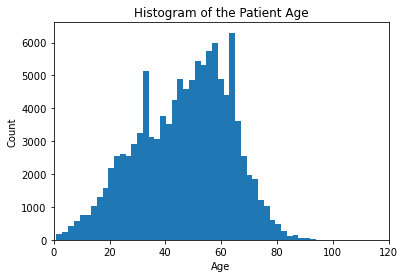

In [63]:
plt.hist(all_xray_df['Patient Age'],bins=200);
plt.xlim(0,120);
plt.title('Histogram of the Patient Age')
plt.xlabel('Age')
plt.ylabel('Count');

As we can see the distribution of the patient age looks pretty normal, maybe a little bit left skewed. This can be expected since this kind of studies seems to be common in adults.

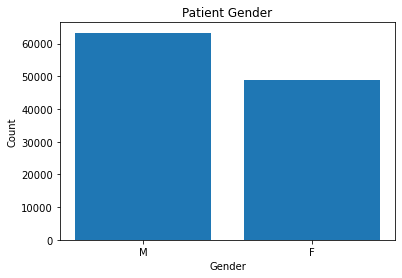

In [64]:
Gender=all_xray_df['Patient Gender'].value_counts()
plt.bar(Gender.index, Gender);
plt.title('Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count');

In [65]:
print('The proportion of males in the study is {}'.format(Gender['M']/all_xray_df.shape[0]))
print('The proportion of females in the study is {}'.format(Gender['F']/all_xray_df.shape[0]))

The proportion of males in the study is 0.5649304316803425
The proportion of females in the study is 0.4350695683196575


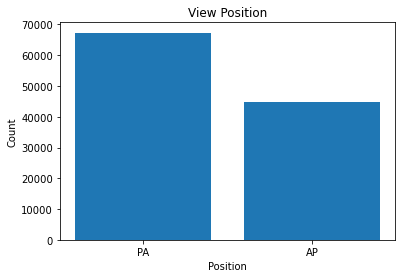

In [66]:
Position=all_xray_df['View Position'].value_counts()
plt.bar(Position.index, Position);
plt.title('View Position')
plt.xlabel('Position')
plt.ylabel('Count');

In [67]:
Position

PA    67310
AP    44810
Name: View Position, dtype: int64

As we can see we have some little sign of imbalance in the View Position and in the Gender variables with slight preference towards males and PA. Now we are going to look for the number of patients with pneumonia.

In [68]:
# number of pneumonia cases
all_xray_df['Pneumonia'].sum()

1431

In [69]:
# number of non-pneumonia cases
all_xray_df.shape[0]-all_xray_df['Pneumonia'].sum()

110689

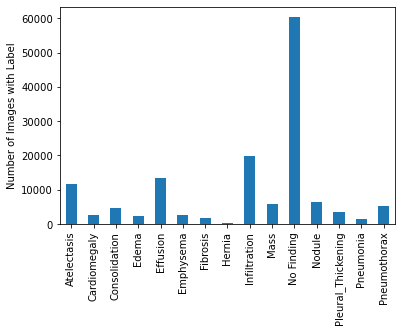

In [70]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label');

In [71]:
all_xray_df['No Finding'].sum()/all_xray_df.shape[0]

0.5383606849803781

 The class Pneumonia is highly imbalanced. It looks like 'No Finding' is the most common occurrence, therefore in 53.8% of this dataset, there is no finding in the image. Beyond that, it appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis.'

In [72]:
commorbid_pneumonia=all_xray_df[all_xray_df['Pneumonia']==1]['Finding Labels'].value_counts()

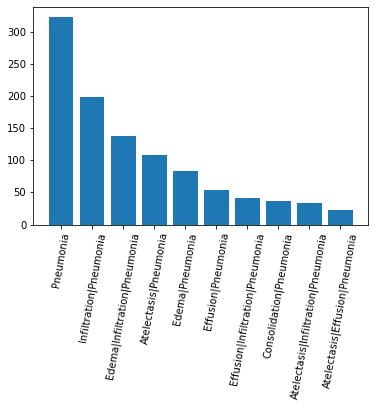

In [73]:
plt.bar(commorbid_pneumonia[:10].index,commorbid_pneumonia[:10])
plt.xticks(rotation=80);

Pneumonia occurs along most of the time, the most common cases that are commorbid with pneumonia are Infiltration, Atelectasis, Edema and Effusion. Let's take a look at their distributions.

In [74]:
Infiltration=all_xray_df['Infiltration'].value_counts()
Infiltration

0    92226
1    19894
Name: Infiltration, dtype: int64

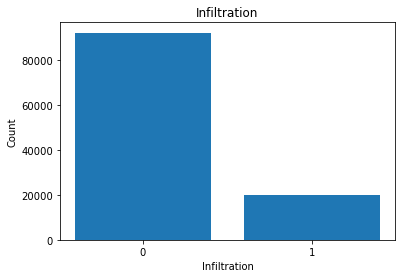

In [75]:
plt.bar(Infiltration.index, Infiltration);
plt.title('Infiltration')
plt.xlabel('Infiltration')
plt.xticks([0,1])
plt.ylabel('Count');

In [76]:
Atelectasis=all_xray_df['Atelectasis'].value_counts()
Atelectasis

0    100561
1     11559
Name: Atelectasis, dtype: int64

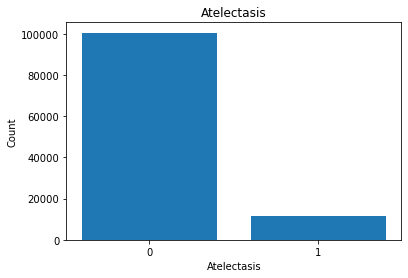

In [77]:
plt.bar(Atelectasis.index, Atelectasis);
plt.title('Atelectasis')
plt.xlabel('Atelectasis')
plt.xticks([0,1])
plt.ylabel('Count');

In [78]:
Edema=all_xray_df['Edema'].value_counts()
Edema

0    109817
1      2303
Name: Edema, dtype: int64

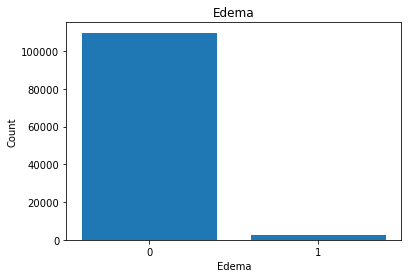

In [79]:
plt.bar(Edema.index, Edema);
plt.title('Edema')
plt.xlabel('Edema')
plt.xticks([0,1])
plt.ylabel('Count');

In [80]:
Effusion=all_xray_df['Effusion'].value_counts()
Effusion

0    98803
1    13317
Name: Effusion, dtype: int64

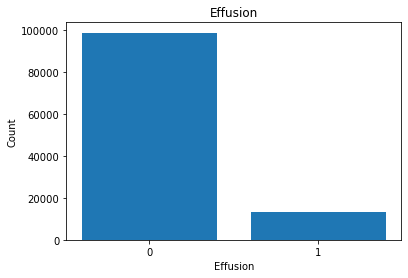

In [81]:
plt.bar(Effusion.index, Effusion);
plt.title('Effusion')
plt.xlabel('Effusion')
plt.xticks([0,1])
plt.ylabel('Count');

As we can see the classes Infiltration, Atelectasis, Edema and Effusion are highly imbalanced. Now let's look at the distribution of the ages of patient with Pneummonia, Infiltration, and Effusion.

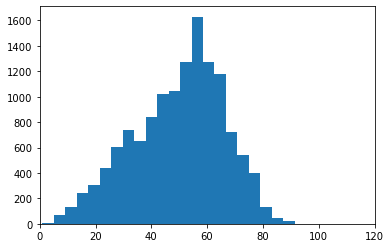

In [82]:
plt.hist(all_xray_df[all_xray_df['Effusion']==1]['Patient Age'],bins=100);
plt.xlim(0,120);

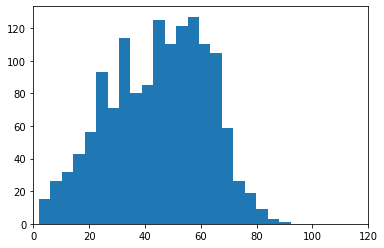

In [83]:
plt.hist(all_xray_df[all_xray_df['Pneumonia']==1]['Patient Age'],bins=100);
plt.xlim(0,120);

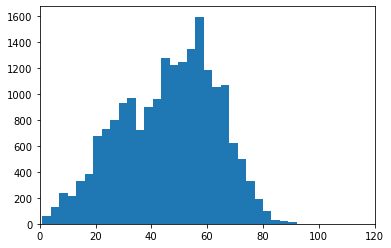

In [84]:
plt.hist(all_xray_df[all_xray_df['Infiltration']==1]['Patient Age'],bins=50);
plt.xlim(0,120);

As we can see the distribution of the ages of patient with Pneummonia, Infiltration, and Effusion look pretty similar between them and with the distribution of total of patients. Now we are going to do Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

In [97]:
sample_df_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df[sample_df['Pneumonia']==1]["Image Index"].map(sample_df_paths.get).sample(2)

2422    /data/images_006/images/00012158_025.png
4177    /data/images_009/images/00020482_061.png
Name: Image Index, dtype: object

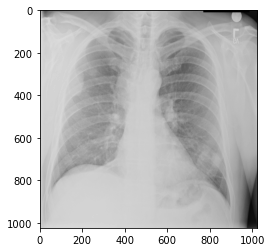

In [106]:
sample_image1 = plt.imread('/data/images_003/images/00004074_000.png')
# Plot the sample image
plt.imshow(sample_image1, cmap='gray');

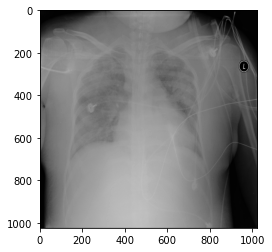

In [118]:
sample_image2 = plt.imread('/data/images_009/images/00020482_061.png')
# Plot the sample image
plt.imshow(sample_image2, cmap='gray');

The images above are from patients with pneumonia, we can apreciate similar patterns in those images. Now we are going to look at the distributions of intensity values of these images. From the histograms of the images with pneumonia we can see that both are left skewed.

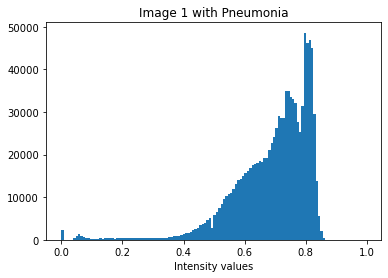

In [119]:
plt.hist(sample_image1.flatten(), bins = 128)
plt.title('Image 1 with Pneumonia')
plt.xlabel('Intensity values');

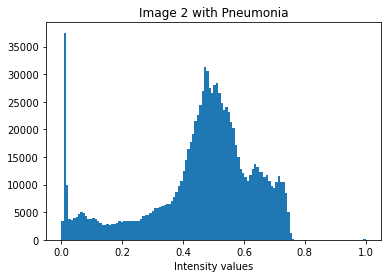

In [120]:
plt.hist(sample_image2.flatten(), bins = 128)
plt.title('Image 2 with Pneumonia')
plt.xlabel('Intensity values');

In [111]:
sample_df[sample_df['Pneumonia']==0]
["Image Index"].map(sample_df_paths.get).sample(1)

4227    /data/images_009/images/00020797_000.png
Name: Image Index, dtype: object

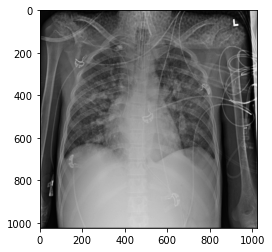

In [116]:
sample_image3 = plt.imread('/data/images_012/images/00030079_061.png')
# Plot the sample image of the patient without pneumonia
plt.imshow(sample_image3, cmap='gray');

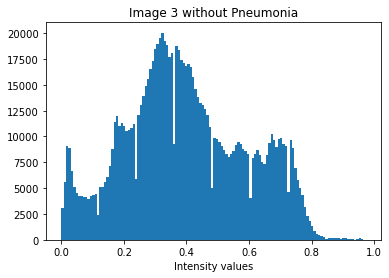

In [117]:
plt.hist(sample_image3.flatten(), bins = 128)
plt.title('Image 3 without Pneumonia')
plt.xlabel('Intensity values');

In the case of the histogram of the patient without pneumonia, the distribution looks pretty normal and we can appreciate differences between the shape of the histograms of patient with and without pneumonia. Now we will look at the histograms of patients with other diseases such as Infiltration and Effusion.

In [140]:
sample_df[sample_df['Infiltration']==1]["Image Index"].map(sample_df_paths.get).sample(1)

3567    /data/images_008/images/00017635_004.png
Name: Image Index, dtype: object

In [125]:
sample_df[sample_df['Effusion']==1]["Image Index"].map(sample_df_paths.get).sample(1)

3252    /data/images_008/images/00016052_014.png
Name: Image Index, dtype: object

In [141]:
sample_image4 = plt.imread('/data/images_008/images/00017635_004.png')
sample_image5 = plt.imread('/data/images_008/images/00016052_014.png')

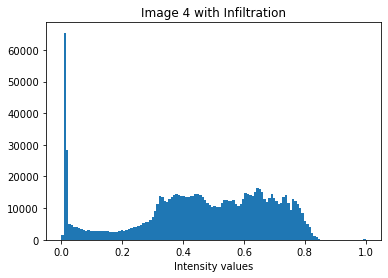

In [142]:
plt.hist(sample_image4.flatten(), bins = 128)
plt.title('Image 4 with Infiltration')
plt.xlabel('Intensity values');

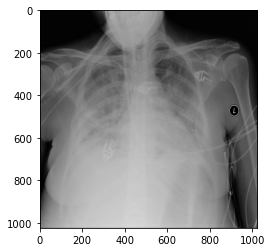

In [143]:
plt.imshow(sample_image4, cmap='gray');

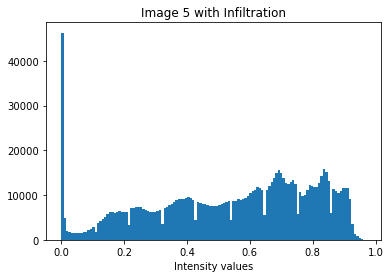

In [144]:
plt.hist(sample_image5.flatten(), bins = 128)
plt.title('Image 5 with Infiltration')
plt.xlabel('Intensity values');

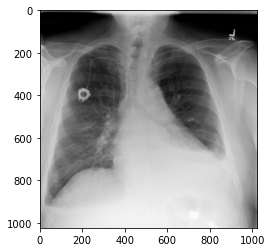

In [145]:
plt.imshow(sample_image5, cmap='gray');

### Conclusions

According to the exploratory data analysis realized, we can arrive to the following insights:

* The classes of Patient Gender and Patient Age are slightly imbalanced.
* The classes of Pneumonia are highly imbalanced. This problem have to be solved before trining.
* We can appreciate differences between the shape of the histograms of the intensity values of patients with and without pneumonia.
* The histograms of the intensity values of patients with Infiltration and  Effusion look similar between them and different to the histograms of patients with pneumonia.